This is backward Euler with a sink term. First we set up all of our conditions, coefficients, etc.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline

# Boundary conditions
b0 = 150  # u(0,t)= b0
bL = 20   # u(L,t)= bL
a = 0 # heat transfer coefficient - along sides of can (for sink term)
D = 0.5 # thermal diffusivity coefficient - in the liquid
u_inf = bL # air temp

# Set parameters
Nt_gaps = 2000    # number of timesteps
T = 1              # final time 
Nt_points = Nt_gaps + 1
t = np.linspace(0.,T,Nt_points)  # times at each time step

Nx_spaces = 100   # number of spaces in x
L = 3 # Length of the can, 1 for now, will need to be changed but this will affect the exact solution as well
Nx_points = Nx_spaces + 1 
x = np.linspace(0, L, Nx_points)    # mesh points in space

dx = x[1] - x[0] 
dt = t[1] - t[0]

C = D*dt/(dx**2) # note: multiplying by thermal diff coeff now!

# Initialize output

# Define the numerical solution 
# the first index is space and the second time
U = np.zeros((Nx_points,Nt_points))

# Set initial conditions (we use u_old to make our loop look nicer below)
u_old = np.zeros(Nx_points)
u_old[0] = b0
u_old[1:] = bL*np.ones(Nx_points-1)
U[:,0] = u_old[:]

# Data structures for the linear system: This will be used as AU_{t+1} = U_t (where U_t is b here) in the simulation
A = np.zeros((Nx_points, Nx_points))
b = np.zeros(Nx_points)

# This is from lectures
for i in range(1, Nx_points-1):
    A[i,i-1] = -C
    A[i,i+1] = -C
    A[i,i] = 1 + 2*C
    
# implement the (constant-in-time) Dirichlet conditions (i.e. the end points never change temp, U(0, t+dt) = U(0, t), same at x=1)
A[0,0] = 1 # NB: USE SCIPY SPARSE MATRIX FOR THIS
A[Nx_points-1,Nx_points-1] = 1

Then we run the simulation. Easy!

In [44]:
# do timestepping (i.e. run simulation)
for n in range(1, Nt_points):
    b = u_old

    # update u by solving the matrix system Au = b
    u_new = np.linalg.solve(A,b) 
    u_new[1:Nx_points-1] -= a*(u_old[1:Nx_points-1] - u_inf) # I have done this because I don't want to subtract this from the end points, since the sink term does not apply there (endpoints are at a constant temp)
    
    # Update u_old before next step
    u_old = u_new
    U[:,n] = u_new

In [45]:
def U_analyt(x, t):
    """x can be a 1-d array"""
    u_d = b0 - bL

    sol = b0 - u_d*(x / L)
    for n in range(1,200):
        sol -= 2*u_d/(n*np.pi) * np.sin(n*np.pi*x/L) * np.exp(-(n*np.pi/L)**2 * D * t)

    return sol

Now we can plot our result for a given time t. You can vary t to see how the temperature distribution looks at various times.

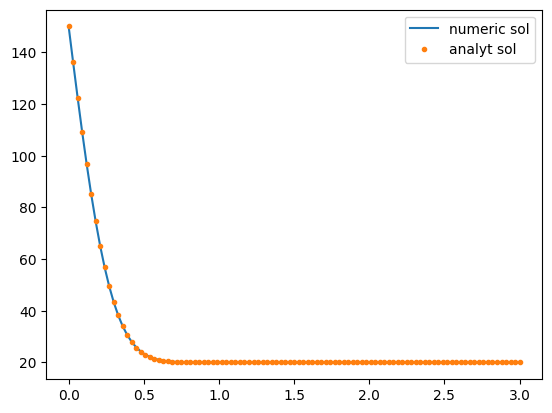

In [46]:
# Plot our numeric U(x,t) at some given time t (note, t is in 1/Nt_points seconds, i.e. U[:, Nt_points] is the solution at time t=1)
t = Nt_points//20
plt.plot(x, U[:, t], "-", label = "numeric sol")
plt.plot(x, U_analyt(x, t/Nt_points), ".", label = "analyt sol")

plt.legend()
plt.show()